In [ ]:
import pandas as pd
import numpy as np

# 파일 경로
malicious_path = "malicious_metadata_with_downloads.csv"
benign_path = "pypi_metadata_clean.csv"

# CSV 파일 읽기
# Adding encoding='latin1' to handle potential UnicodeDecodeError
malicious_df = pd.read_csv(malicious_path, encoding='latin1')
benign_df = pd.read_csv(benign_path, encoding='latin1')

# 라벨링
malicious_df["label"] = 1
benign_df["label"] = 0

# 균형 맞추기: 더 적은 쪽 기준으로 샘플링
min_size = min(len(malicious_df), len(benign_df))
malicious_sample = malicious_df.sample(n=min_size, random_state=42)
benign_sample = benign_df.sample(n=min_size, random_state=42)

# 병합 및 셔플
combined_df = pd.concat([malicious_sample, benign_sample], ignore_index=True)
shuffled_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# 전체 데이터 저장
shuffled_df.to_csv("balanced_metadata.csv", index=False)

# package + label만 저장
package_label_df = shuffled_df[["package", "label"]]
package_label_df.to_csv("package_labels.csv", index=False)

#데이터 전처리 및 정규화

###이 부분을 잠시 제외( 쓸모없는 데이터)

In [ ]:
"""
# 블록리스트 파일 로딩
with open("disposable_email_blocklist.conf") as f:
    disposable_domains = {line.strip().lower() for line in f if line.strip()}

# 도메인 비교 함수
def is_disposable(domain):
    # Handle non-string values by converting to string and filling NaNs
    return str(domain).lower() in disposable_domains

# Convert the column to string type and fill NaN values before applying the function
df["is_disposable"] = df["email_domain"].astype(str).apply(is_disposable)
"""

In [ ]:
import pandas as pd

# Use the same encoding as in the first cell
df = pd.read_csv("balanced_metadata.csv", encoding='latin1')
df["email_domain"] = df["author_email"].str.extract(r"@(.+)")

In [ ]:
from collections import Counter
import math
import numpy as np
import re

# 1️⃣ 다운로드 수 정규화 (로그 변환)
df["download_log"] = df["download"].apply(lambda x: np.log1p(x))

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df["download_scaled"] = scaler.fit_transform(df[["download_log"]])


# 다운로드 이상치 플래그 (너무 적거나 너무 많음)
#low_threshold = df["download_log"].quantile(0.05)
#high_threshold = df["download_log"].quantile(0.95)

#df["download_too_low"] = df["download_log"] < low_threshold
#df["download_too_high"] = df["download_log"] > high_threshold

# 2️⃣ 설명 길이 분석
df["summary"] = df["summary"].fillna("")
df["summary_length"] = df["summary"].apply(len)

# 설명 길이 기준 플래그
df["summary_too_short"] = df["summary_length"] < 10
df["summary_too_long"] = df["summary_length"] > 300

# 3️⃣ 설명 자동 생성 여부 추정 (엔트로피 기반)
def shannon_entropy(s):
    if not s:
        return 0
    prob = [v / len(s) for v in Counter(s).values()]
    return -sum(p * math.log2(p) for p in prob)

df["summary_entropy"] = df["summary"].apply(shannon_entropy)
df["summary_low_entropy"] = df["summary_entropy"] < 3.5  # 자동 생성 의심 기준

# 4️⃣ 버전 형식 검증
def is_valid_version(v):
    return bool(re.match(r"^\d+\.\d+\.\d+$", str(v).strip()))

df["version_valid"] = df["version"].apply(is_valid_version)

In [ ]:
import pandas as pd
import requests
import re
from Levenshtein import distance as levenshtein_distance

# 1. PyPI 상위 패키지 목록 가져오기
def get_pypi_top_packages():
    url = "https://hugovk.github.io/top-pypi-packages/top-pypi-packages-30-days.json"
    response = requests.get(url)
    data = response.json()
    return [pkg['project'] for pkg in data['rows']]

# 2. 핵심 단어만 추출 (예: requests-test → requests)
def extract_core_name(name):
    return re.split(r"[-_.]", name.lower())[0]

# 3. 오타 기반 악성 탐지 함수
def is_typo_like(pkg_name, legit_list):
    name = extract_core_name(pkg_name)
    for legit in legit_list:
        legit_core = extract_core_name(legit)
        # 오타 거리 1이면서 길이 차이 1 이하, 접두/접미어 없음
        if levenshtein_distance(name, legit_core) == 1 and abs(len(name) - len(legit_core)) <= 1:
            return True
    return False

# 4. 데이터셋
pypi_packages = get_pypi_top_packages()

# 5. 피처 생성
df["is_typo_like"] = df["package"].apply(lambda x: is_typo_like(str(x), pypi_packages))



# 7. 확인
print(df[["package", "is_typo_like"]].head())


    package  is_typo_like
0  1337test         False
1      a1rn         False
2    a2wsgi         False
3      acme          True
4     acora         False


In [ ]:
df.to_csv("balanced_metadata_enriched.csv", index=False)


In [ ]:
import pandas as pd

# 두 CSV 파일 불러오기
df_main = pd.read_csv("balanced_metadata_enriched.csv", encoding="utf-8-sig")
df_extra = pd.read_csv("package_vulnerability_analysis.csv", encoding="utf-8-sig")

# BOM 제거 (혹시 모를 깨짐 방지)
df_main.columns = [col.replace('\ufeff', '') for col in df_main.columns]
df_extra.columns = [col.replace('\ufeff', '') for col in df_extra.columns]

# 각 파일의 package 목록 집합으로 변환
main_packages = set(df_main["package"].dropna().unique())
extra_packages = set(df_extra["package"].dropna().unique())

# 중복되지 않은 package 이름 찾기
only_in_main = main_packages - extra_packages
only_in_extra = extra_packages - main_packages

# 결과 출력
print(f"✅ balanced_metadata_enriched.csv에만 있는 package 수: {len(only_in_main)}")
print(f"✅ extra_features.csv에만 있는 package 수: {len(only_in_extra)}")


✅ balanced_metadata_enriched.csv에만 있는 package 수: 1527
✅ extra_features.csv에만 있는 package 수: 582


In [ ]:
import pandas as pd

# 두 CSV 파일 불러오기
df_main = pd.read_csv("balanced_metadata_enriched.csv", encoding="utf-8-sig")
df_extra = pd.read_csv("package_vulnerability_analysis.csv", encoding="utf-8-sig")

# BOM 제거 (혹시 모를 깨짐 방지)
df_main.columns = [col.replace('\ufeff', '') for col in df_main.columns]
df_extra.columns = [col.replace('\ufeff', '') for col in df_extra.columns]

# 각 파일의 package 목록 집합으로 변환
main_packages = set(df_main["package"].dropna().unique())
extra_packages = set(df_extra["package"].dropna().unique())

# 중복된 package 이름 찾기
common_packages = main_packages & extra_packages

# 결과 출력
print(f"✅ 두 파일에 모두 존재하는 중복된 package 수: {len(common_packages)}")


✅ 두 파일에 모두 존재하는 중복된 package 수: 1640


In [ ]:
import pandas as pd

# CSV 파일 불러오기
df = pd.read_csv("balanced_metadata_enriched_with_labels.csv", encoding="utf-8-sig")

# 컬럼 이름 출력
print("✅ 전체 컬럼 목록:")
for col in df.columns:
    print(col,end=', ')


✅ 전체 컬럼 목록:
package, label, email_domain, is_disposable, download_log, download_too_low, summary_length, summary_too_short, summary_too_long, summary_entropy, summary_low_entropy, version_valid, is_typo_like, vulnerability_status, cwe_label, 

In [ ]:
import pandas as pd

# 1. 파일 불러오기
main_df = pd.read_csv("balanced_metadata_enriched.csv", encoding="utf-8")
extra_df = pd.read_csv("package_vulnerability_analysis.csv", encoding="utf-8-sig")  # 여기에 vulnerability_status, cwe_label 포함
print(extra_df[:10])
# 2. 병합 (package 기준으로 정확히 일치하는 행만)
merged_df = pd.merge(main_df, extra_df[["package", "vulnerability_status", "cwe_label"]], on="package", how="left")

print(merged_df[:10])
# 3. 결과 저장
merged_df.to_csv("balanced_metadata_enriched_with_labels.csv", index=False)
print("✅ 병합 완료: balanced_metadata_enriched_with_labels.csv 생성됨")


                   package vulnerability_status  cwe_label
0                   forgyp           Vulnerable  malicious
1                  litellm       Not Vulnerable     Benign
2               ptyprocess           Vulnerable  malicious
3                 filelock       Not Vulnerable     Benign
4                     face       Not Vulnerable     Benign
5          selfinfopushpip           Vulnerable  malicious
6  music-source-separation           Vulnerable  malicious
7       py-candyintcontrol           Vulnerable  malicious
8                  jsonref       Not Vulnerable     Benign
9        selfrandompostint           Vulnerable  malicious
                                    package  label     email_domain  \
0                                  1337test    1.0      tartley.com   
1                                      a1rn    1.0      example.com   
2                                    a2wsgi    0.0  abersheeran.com   
3                                      acme    0.0          eff.org

In [ ]:
import pandas as pd

# 1. CSV 파일 불러오기
df = pd.read_csv("balanced_metadata_enriched_with_labels.csv", encoding="utf-8-sig")

# 2. BOM 제거 (혹시 모를 깨짐 방지)
df.columns = [col.replace('\ufeff', '') for col in df.columns]

# 3. "vulnerability_status", "cwe_label"가 비어있는 행 제거
df.dropna(subset=["vulnerability_status", "cwe_label"], inplace=True)

# 4. 값 변환: 문자열 → 숫자
df["vulnerability_status"] = df["vulnerability_status"].map({
    "Vulnerable": 1,
    "Not Vulnerable": 0
})

df["cwe_label"] = df["cwe_label"].map({
    "malicious": 1,
    "benign": 0
})

# 5. 결과 확인
print("✅ 변환 완료. 남은 데이터 수:", len(df))
print(df[["package", "vulnerability_status", "cwe_label"]].head())
print(df.head(10))
df.to_csv("balanced_final.csv", index=False)


✅ 변환 완료. 남은 데이터 수: 1640
          package  vulnerability_status  cwe_label
0        1337test                   1.0        1.0
1            a1rn                   1.0        1.0
3            acme                   0.0        NaN
6  activedevbadge                   1.0        1.0
9          adanbu                   1.0        1.0
           package  label email_domain  is_disposable  download_log  \
0         1337test    1.0  tartley.com          False      5.043425   
1             a1rn    1.0  example.com          False      5.950643   
3             acme    0.0      eff.org          False     19.092790   
6   activedevbadge    1.0  outlook.com          False      4.962845   
9           adanbu    1.0  outlook.com          False      4.709530   
10          adandu    1.0  outlook.com          False      4.955827   
11          adandv    1.0  outlook.com          False      4.859812   
15    advpruebitaa    1.0  example.com          False      4.543295   
16   advpruebitaa3    1.0  exam

In [ ]:
import pandas as pd

# 1. CSV 파일 불러오기
df = pd.read_csv("balanced_metadata_enriched_with_labels.csv", encoding="utf-8-sig")

# 2. BOM 제거 (혹시 모를 깨짐 방지)
df.columns = [col.replace('\ufeff', '') for col in df.columns]


# 4. 값 변환: 문자열 → 숫자
df["vulnerability_status"] = df["vulnerability_status"].map({
    "Vulnerable": 1,
    "Not Vulnerable": 0
})

df["cwe_label"] = df["cwe_label"].map({
    "malicious": 1,
    "benign": 0
})

# 3. 모든 결측치 -1로 대체
df.fillna(-1, inplace=True)

# 5. 새 CSV로 저장
df.to_csv("balanced_final_renew.csv", index=False, encoding="utf-8-sig")
print(f"✅ 저장 완료: balanced_final.csv (총 {len(df)}개 행)")


✅ 저장 완료: balanced_final.csv (총 3167개 행)


In [ ]:
import pandas as pd

# 1. CSV 파일 불러오기
df = pd.read_csv("balanced_final33.csv", encoding="utf-8-sig")

# 2. BOM 제거 (혹시 모를 깨짐 방지)
df.columns = [col.replace('\ufeff', '') for col in df.columns]

# 3. 모든 컬럼 기준으로 결측치가 있는 행 제거
df_cleaned = df.dropna()

# 4. 결과 저장
df_cleaned.to_csv("balanced_final_cleaned.csv", index=False, encoding="utf-8-sig")
print(f"✅ 결측치 제거 완료: balanced_final_cleaned.csv (총 {len(df_cleaned)}개 행)")


✅ 결측치 제거 완료: balanced_final_cleaned.csv (총 1060개 행)


In [ ]:
import pandas as pd

# CSV 파일 불러오기
df = pd.read_csv("balanced_metadata_enriched_with_labels.csv", encoding="utf-8-sig")

# label 값 비율 계산
label_counts = df["label"].value_counts(normalize=True)

# 결과 출력
print("✅ label 비율:")
print(f"1 (악성): {label_counts.get(1, 0):.2%}")
print(f"0 (정상): {label_counts.get(0, 0):.2%}")


✅ label 비율:
1 (악성): 49.78%
0 (정상): 50.22%


In [ ]:
import pandas as pd

# 1. CSV 파일 불러오기
df = pd.read_csv("balanced_final.csv", encoding="utf-8-sig")

# 2. BOM 제거 (혹시 모를 깨짐 방지)
df.columns = [col.replace('\ufeff', '') for col in df.columns]

# 3. 모든 결측치 -1로 대체
df.fillna(-1, inplace=True)

# 4. 결과 저장
df.to_csv("balanced_final_filled.csv", index=False, encoding="utf-8-sig")
print(f"✅ 결측치 -1로 대체 완료: balanced_final_filled.csv (총 {len(df)}개 행)")


#데이터 학습 코드

데이터 로딩 및 전처리


📊 Random Forest 결과
정확도: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       319
           1       1.00      1.00      1.00       313

    accuracy                           1.00       632
   macro avg       1.00      1.00      1.00       632
weighted avg       1.00      1.00      1.00       632


📊 XGBoost 결과
정확도: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       319
           1       1.00      1.00      1.00       313

    accuracy                           1.00       632
   macro avg       1.00      1.00      1.00       632
weighted avg       1.00      1.00      1.00       632


📊 Logistic Regression 결과
정확도: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       319
           1       1.00      1.00      1.00       313

    accuracy                           1.00       632
   macro avg       1.00      1.00      1.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:54:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/tmp/ipython-input-3039663497.py:126: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


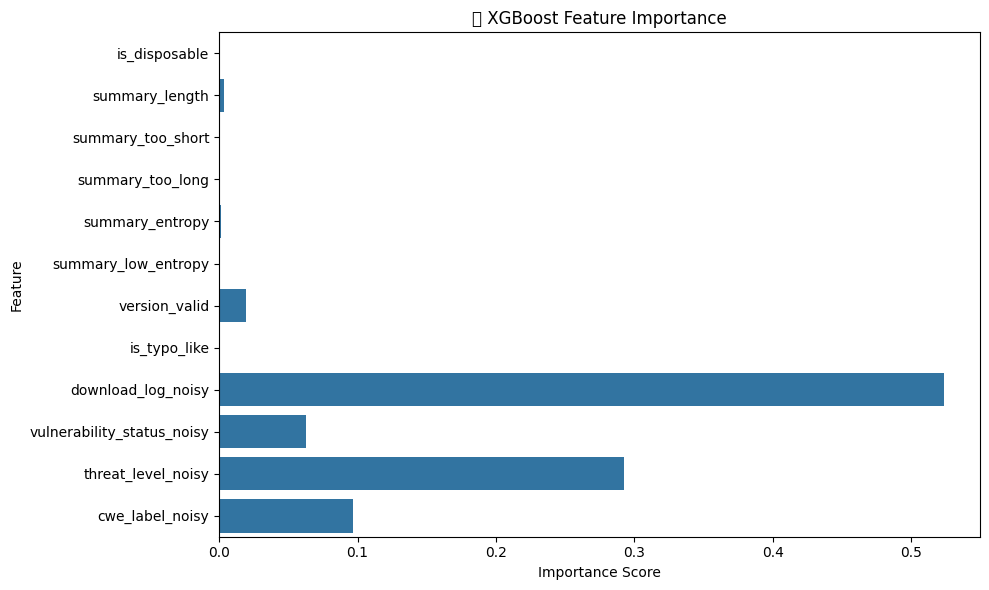

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# 1. 데이터 로딩
df = pd.read_csv("balanced_final_renew.csv", encoding="utf-8-sig")
df.columns = [col.replace('\ufeff', '') for col in df.columns]


# 결측치가 있을 경우 -1로 대체 (이미 처리된 상태라면 생략 가능)
df.fillna(0, inplace=True)

# vulnerability_status와 cwe_label을 기반으로 새로운 피처 생성
def combined_threat(row):
    if row["vulnerability_status"] == 1 and row["cwe_label"] == 1:
        return 2
    elif row["vulnerability_status"] == 1 or row["cwe_label"] == 1:
        return 1
    else:
        return 0

df["threat_level"] = df.apply(combined_threat, axis=1)


#scaler = StandardScaler()
#df["download_scaled"] = scaler.fit_transform(df[["download_log"]])
# 3. download_log 스케일링 (0~1 범위로 정규화)
#scaler = MinMaxScaler()
#df["download_log_scaled"] = 1-scaler.fit_transform(df[["download_log"]])

# 4. is_typo_like를 숫자형으로 변환 (True → 1, False → 0)
#df["is_typo_like_num"] = df["is_typo_like"].astype(int)

# 5. 새로운 피처 생성: 낮은 다운로드 수 + 유명 라이브러리 이름 흉내
# → 다운로드 수가 낮을수록 값이 작아지므로 (1 - scaled)로 반전
#df["low_download_typo_score"] = (1 - df["download_log_scaled"]) * df["is_typo_like_num"]


# 노이즈 추가 대상 피처
target_features = ["vulnerability_status", "cwe_label", "download_log", "threat_level"]

# 노이즈 추가 함수
def add_noise(series, noise_level=0.05):
    return series + np.random.normal(0, noise_level, size=len(series))

# 각 피처에 노이즈 적용
for feature in target_features:
    df[feature + "_noisy"] = add_noise(df[feature].astype(float))





# 2. label 값이 0 또는 1인 행만 유지
df = df[df["label"].isin([0, 1])]

# 3. 사용할 피처 선택
features = [
    "is_disposable",
    #"download_log", "download_too_low","vulnerability_status","threat_level","cwe_label"
    "summary_length", "summary_too_short", "summary_too_long",
    "summary_entropy", "summary_low_entropy", "version_valid",
    "is_typo_like",  #"low_download_typo_score",#"download_log_scaled",

    "download_log_noisy",
    "vulnerability_status_noisy","threat_level_noisy","cwe_label_noisy"


]

# 4. X, y 분리
X = df[features].astype(float)
y = df["label"].astype(int)

# 5. 학습/테스트 분할
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. 모델 학습 및 평가 함수
def train_and_evaluate(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n📊 {name} 결과")
    print("정확도:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

# 7. 모델 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
#xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
lr_model = LogisticRegression(max_iter=1000)


xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',

    # 🔧 구조 제약
    max_depth=3,               # 트리 깊이 제한 → 과도한 분할 방지
    colsample_bytree=0.4,      # 피처 샘플링 → 일부 피처만 사용하도록 유도
    subsample=0.7,             # 데이터 샘플링 → 과적합 방지
    reg_alpha=0.2,             # L1 정규화 → 피처 선택에 패널티 부여
    reg_lambda=0.2,            # L2 정규화 → 과도한 피처 영향력 억제
    random_state=42
)



train_and_evaluate(rf_model, "Random Forest")
train_and_evaluate(xgb_model, "XGBoost")
train_and_evaluate(lr_model, "Logistic Regression")

# 8. XGBoost 피처 중요도 시각화
importances = xgb_model.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("📌 XGBoost Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


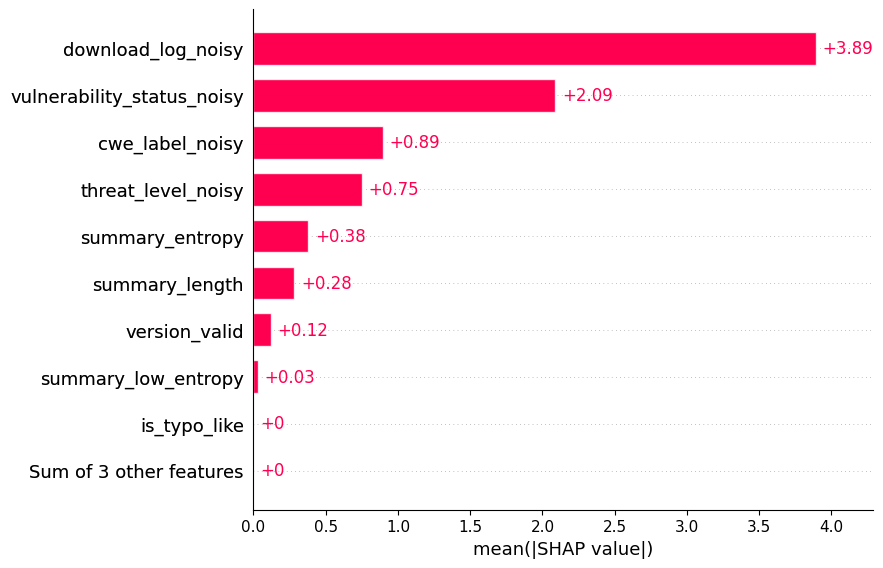

In [ ]:
import shap
explainer = shap.Explainer(xgb_model, X_test)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)


모델 학습 및 평가 함수

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

def train_and_evaluate(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n📊 {name} 결과")
    print("정확도:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))


모델 실행

피처 중요도 시각

In [ ]:
import pandas as pd

# CSV 파일 불러오기
# Use the same encoding as in the first cell
df1 = pd.read_csv('balanced_metadata.csv', encoding='latin1')
df2 = pd.read_csv('package_labels.csv', encoding='latin1')

# 각 파일의 package 컬럼에서 중복된 값만 추출
common_packages = pd.Series(list(set(df1['package']) & set(df2['package'])))

# 중복된 package 값만 남기고 나머지 제거
df1_filtered = df1[df1['package'].isin(common_packages)].reset_index(drop=True)
df2_filtered = df2[df2['package'].isin(common_packages)].reset_index(drop=True)

# 결과 확인
print("Filtered df1:")
display(df1_filtered.head())

print("\nFiltered df2:")
display(df2_filtered.head())

In [ ]:
import pickle

# 모델 학습 예시 (이미 학습된 모델이라고 가정)
# rf_model = RandomForestClassifier(...)
# lr_model = LogisticRegression(...)
# xgb_model = xgb.XGBClassifier(...)

# 모델 저장
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

with open('logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

print("✅ 모든 모델이 pickle 파일로 저장되었습니다.")


✅ 모든 모델이 pickle 파일로 저장되었습니다.


In [ ]:
!pip install Levenshtein